### Vinícius Rodrigues Ferraz

## Recurrent Neural Networks

**RNNs are Neural Networks that allows previous outputs to be used as inputs (inputs and outputs have the same shape), while having hidden states.  
RNNs are used to deal with sequential/temporal informations, since each epoch in RNN is an time step.**

<img src="img/RNN.png" alt="drawing" width="600" align="left"/>

**As I made in the ANN Notebook, first I'll find some RNN work to take as a base, so I can learn in the process and apply it form myself later.**

**NOTES:**  
   - **I'll use [This Work](https://www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html) from datatechnotes to learn how to code an RNN**
       - **All merits of this first work must be given to the author.**
   - **After this, to apply what I've learned, I'll try to make on my own a RNN predict the next dinner. This is an example that I saw when I was learning about RNNs.**
   - **Last, I'll try to make on my own a _BTC Price Predict_ applying LSTMs.**

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,Embedding

Using TensorFlow backend.


**Generating sequential dataset**

In [2]:
n = 1000
train_point = int(0.8*n)

t = np.arange(0,n)
X = np.sin((0.02*t)+2*np.random.rand(n)) #Multiplications done to make the graph "clean"

**Visualizing the data**

In [3]:
df = pd.DataFrame(X)
df.head(3)

,0
0,0.711429
1,0.890527
2,0.648375


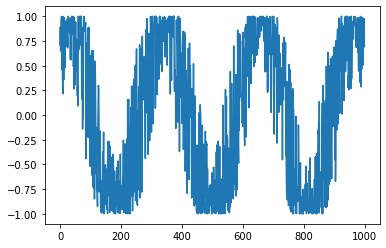

In [4]:
plt.plot(df)

**Now we will make the Train and the Test Data**
****
**RNN requires sequential Data but also requires a step**

In [5]:
step = 4

**For RNN our input need to be the same shape. When we make a step it brokes the last numbers like:**  
data = 1-10 | step = 4  
x = 1 y = 5  
x = 2 y = 6  
...  
x = 10 y = 14 (14 not in data)

In [6]:
values = df.values
train,test = values[0:train_point,:], values[train_point:n,:]
#train.shape = (800,1)

In [7]:
step = 4
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
train.shape # = (804,1)

(804,)

In [8]:
# convert into dataset matrix
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [9]:
trainX,trainY =convertToMatrix(train,step)
print(trainX.shape)
testX,testY =convertToMatrix(test,step)

(800, 4)


In [10]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(800, 1, 4)

In [11]:
trainY.shape

(800,)

**Split ok**

In [12]:
#(batch_size, timesteps, input_dim)
def RNN():
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
    model.add(Dense(8,activation="relu"))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error",optimizer="adam")
    return model

In [13]:
#print(trainX.shape,trainy.shape)
model = RNN()
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=0)

In [14]:
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

In [15]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

0.15087911620736122


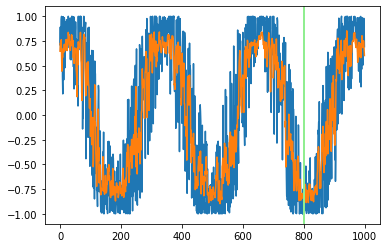

In [16]:
index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[train_point], c="lightgreen",lw=2)
plt.show() 

**OK! It works, but I will apply it on another sample.**

**Since RNNs can treat sequence problems let's supose this case:  
 My roomate always make the same dinner, based on the day of week.  
     Monday    - Pizza  
     Tuesday   - Burguer  
     Wednesday - Pancake  
     Thursday  - spaghetti  
     Friday    - Meat  
     Saturday  - Chicken  
     Sunday    - Sausage**

**To make the work easy, I'll set numbers instead of strings**

**Dataset Creation**

In [17]:
#dayofweek = ["Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday"]
dayofweek = [1,2,3,4,5,6,7]
#dinner = ["Pizza","Burguer","Pancake","Spaghetti","Meat","Chicken","Sausage"]
dinner = [1,2,3,4,5,6,7]

#Repeating for greater dataset
dayofweek = np.array(144*dayofweek) # = 1008 days
dinner = np.array(144*dinner)

**Train/Test Split**

**Time-step will be 2, so, given the previous 2 days, the RNN will discover what's the next food  
Given Monday(1) and Tuesday(2) RNN have to return Pancake(3)**

In [18]:
# Time-step
tstep = 2

# train = ~80% | test = ~20%
tp = 800

trainX, trainY = dayofweek[0:tp], dinner[0:tp]
testX, testY = dayofweek[tp:], dinner[tp:]

In [19]:
testX.shape

(208,)

**Fixing dimensions**

In [20]:
def makematrix(dataX, dataY, tstep):
    X, Y = [], []
    for i in range(len(dataX)-tstep):
        X.append(dataX[i:i+tstep,])
        Y.append(dataY[i+tstep])
    return np.array(X), np.array(Y)

In [21]:
trainX, trainY = makematrix(trainX, trainY, tstep)
testX, testY = makematrix(testX, testY, tstep)

In [22]:
testX.shape

(206, 2)

**RNNs require 3 dimensional inputs, so we have to reshape it**

In [23]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, tstep))
testX = np.reshape(testX, (testX.shape[0], 1, tstep))

**I'll create a graph function to plot future models**

In [24]:
def graph(hist):
    # Plots Loss Line.
    plt.plot(hist.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    lss = str(hist.history['loss'][-1])
    plt.title(str('Loss='+lss))
    plt.show()

#### Defining the Model.  
**Our model is a Recurrent Neural Network with 32 recurrent units and 1 hidden layer with 8 neurons  
Relu is used as the activation function.  
Mean Squared Error is used as Loss Function with Adam optimizer.**

In [25]:
def RNN():
    model = Sequential()
    import keras
    keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=5)
    model.add(SimpleRNN(units=32, input_shape=(1,tstep), kernel_initializer="RandomNormal",activation="relu"))
    model.add(Dense(1))
    keras.optimizers.Adam(decay=1e-6,learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False )
    model.compile(loss="mean_squared_error",optimizer="adam")
    return model

In [26]:
model = RNN()
hist = model.fit(trainX, trainY, epochs=400, batch_size=32, verbose=0)

In [27]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict),axis=0)

In [28]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

0.018979609530783238


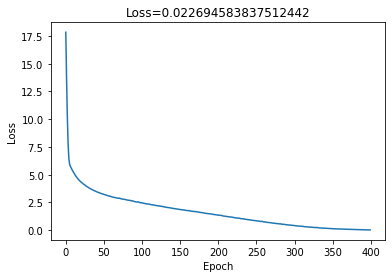

In [29]:
graph(hist)

**Remembering**  
**dayofweek = 
    ["Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday"]  
dayofweek = 
    [----1----,-----2----,-------3-----,------4-----,----5----,----6-----,----7----]**

**dinner = 
    ["Pizza","Burguer","Pancake","Spaghetti","Meat","Chicken","Sausage"]  
dinner =
    [----1---,-----2-----,------3-----,------4------,----5----,----6-----,-----7-----]**

In [30]:
seq = np.array([[[1, 2]],[[4, 5]],[[7, 1]]])
# NextDay: [Wednesday],[Saturday],[Tuesday]
# Returns: Pancake, Chicken, Burguer
#           3.0      6.0      2.0

for i in model.predict(seq):
    if round(i[0]) == 1:
        print('\n',round(i[0],3))
        print("Pizza")
    elif round(i[0]) == 2:
        print('\n',round(i[0],3))
        print("Burguer")
    elif round(i[0]) == 3:
        print('\n',round(i[0],3))
        print("Pancake")
    elif round(i[0]) == 4:
        print('\n',round(i[0],3))
        print("Spaghetti")
    elif round(i[0]) == 5:
        print('\n',round(i[0],3))
        print("Meat")
    elif round(i[0]) == 6:
        print('\n',round(i[0],3))
        print("Chicken")
    else:
        print("Sausage")



 3.068
Pancake

 5.96
Chicken

 2.01
Burguer


### It works!
****
****
****
**OK! Now I'll try to predict BTC prices, based on both these previous works  
But this time I'll use LSTM**
<br><br>
**For sure the results won't be too close to the real value, since I'm using simple inputs and an simple Neural Network.**

## Long Short-Term Memory

**LSTMs are an special kind of RNNs.  
LSTMs can memorize past terms better than RNN**

<img src="img/LSTM.png" alt="drawing" width="420" align="left"/>
<img src="img/LSTM2.png" alt="drawing" width="500" align="left"/>

In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [32]:
btcdf = pd.read_csv('data/Bitcoin_Historical_Price.csv')

In [33]:
btcdf['Date'] = pd.to_datetime(btcdf['Date'])
btcdf.head(3)

,Date,Close
0,2013-04-27,134.21
1,2013-04-28,144.54
2,2013-04-29,139.00


In [34]:
btcdf['Close'] = btcdf['Close']/btcdf['Close'].max()

In [35]:
group = btcdf.groupby('Date')

In [36]:
Real_Price = group['Close'].mean()

In [37]:
Real_Price[:3]

Date
2013-01-05    0.005396
2013-01-06    0.006272
2013-01-07    0.004623
Name: Close, dtype: float64

In [38]:
Real_Price.shape

(1772,)

1772 values - I'll split at 1400 = ~80%

In [39]:
split_point = 1400
step = 30
X_train = Real_Price[:split_point]
y_train = Real_Price[step:split_point+step] # 30 days after train
X_test = Real_Price[split_point:-step] # Values until the 30th last value
y_test = Real_Price[split_point+step:] # 30 days after test

In [40]:
def makematrix(dataX, dataY, step):
    X, Y = [], []
    for i in range(len(dataX)-step):
        X.append(dataX[i:i+step,])
        Y.append(dataY[i+step])
    return np.array(X), np.array(Y)

In [41]:
X_train, y_train = makematrix(X_train, y_train, step)
X_test, y_test = makematrix(X_test, y_test, step)

In [42]:
X_train.shape

(1370, 30)

**Everything is OK!  
Reshaping to 3 dimensional**

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, step))
X_test = np.reshape(X_test, (X_test.shape[0], 1, step))

In [44]:
X_train.shape

(1370, 1, 30)

In [45]:
#X_train = sc.fit_transform(X_train)
#X_test = sc.fit_transform(X_test)

In [46]:
from keras.layers import LSTM

In [47]:
def BTC_RNN():
    model = Sequential()
    model.add(LSTM(units=64, activation="sigmoid", input_shape=(1,step)))
    model.add(Dense(units=1))
    import keras
    keras.optimizers.Adam(decay=1e-6,learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False )
    model.compile(loss="mean_squared_error",optimizer="adam")
    return model

In [48]:
model = BTC_RNN()
hist1 = model.fit(X_train, y_train, batch_size=32, epochs=5)

Epoch 1/5
1370/1370 [==============================] - 1s 646us/step - loss: 0.0108
Epoch 2/5
1370/1370 [==============================] - 0s 106us/step - loss: 0.0012
Epoch 3/5
1370/1370 [==============================] - 0s 93us/step - loss: 0.0011
Epoch 4/5
1370/1370 [==============================] - 0s 171us/step - loss: 0.0010
Epoch 5/5
1370/1370 [==============================] - 0s 101us/step - loss: 9.7502e-04


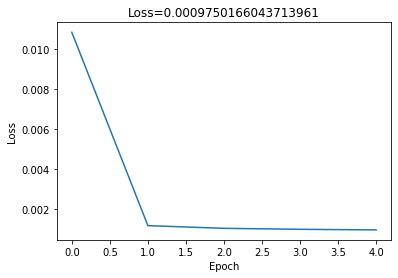

In [49]:
graph(hist1)

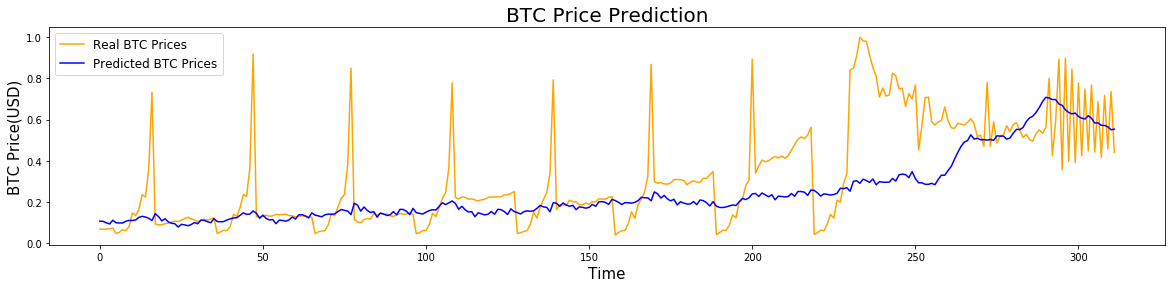

In [50]:
X = y_test
y = model.predict(X_test)
plt.figure(figsize=(20,4))
plt.plot(X,color='orange', label='Real BTC Prices')
plt.plot(y,color='b', label = 'Predicted BTC Prices')
plt.legend(loc=2, prop={'size': 12})
plt.title('BTC Price Prediction', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('BTC Price(USD)', fontsize=15)
plt.show()